In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon', quiet=True)


True

# Turnover Reason: Unsupervised Learning

In this model we are change the target to turnover_reason. This is the reason given for why the employee left. Understanding this reason better will allow us to add more nuaunce to our initial predictive model. 

## Setup and Additional Exploration

### Restore Variables from explore.ipynb

Use IPython's `%store -r` to restore the `df` dataframe and `continuous_vars` list that were stored at the end of `explore.ipynb`.

**Important**: Make sure you've run `explore.ipynb` first (at least up to the `%store` cells at the end) before running this notebook.

In [2]:
# Restore variables from explore.ipynb (suppress warnings)
import warnings
warnings.filterwarnings('ignore')

%store -r df
%store -r continuous_vars

# Verify they loaded
if 'df' not in locals():
    raise RuntimeError("df was not restored. Make sure you've run explore.ipynb and executed the %store cells at the end.")
if 'continuous_vars' not in locals():
    raise RuntimeError("continuous_vars was not restored. Make sure you've run explore.ipynb and executed the %store cells at the end.")

In [35]:
# Verify the variables were restored successfully
print(f"DataFrame shape: {df.shape}")
print(f"Continuous variables ({len(continuous_vars)}): {continuous_vars[:5]}...")  # show first 5
df.head(3)

DataFrame shape: (849999, 33)
Continuous variables (20): ['tenure_months', 'salary', 'performance_score', 'satisfaction_score', 'workload_score']...


,employee_id,role,job_level,department,tenure_months,salary,performance_score,satisfaction_score,workload_score,team_sentiment,...,burnout_risk,left_company,turnover_reason,risk_factors_summary,turnover_probability_generated,persona_name,role_complexity_score,career_progression_score,salary_rank,feedback_sentiment_score
0,SYN_00000000,Anonymous Employee,Mid,Research & Development,169,79704.579059,0.632482,0.623746,0.758117,0.662335,...,0.866643,False,Not Applicable,Severe Burnout Risk,0.290979,ChangeResistor,0.2,1.000000,0.490089,0.7351
1,SYN_00000001,Customer Success Manager,Manager,Research & Development,54,29694.288831,0.538587,0.982556,0.788416,0.934661,...,0.218996,False,Not Applicable,Low Risk,0.156002,NewEnthusiast,0.2,1.000000,0.946494,0.9509
2,SYN_00000002,Administrative Assistant,Entry,HR,1,62208.470185,0.624656,0.767200,0.697617,0.888559,...,0.541531,True,Personal / Relocation,Low Risk,0.233897,NewEnthusiast,0.2,0.836495,0.620677,0.8999


In [36]:
#add salary rank 
df['salary_rank'] = df.groupby(['job_level', 'role'])['salary'].rank(pct=True, ascending=False)
df['salary_rank'].head()

0    0.490089
1    0.946494
2    0.620677
3    0.001948
4    0.770605
Name: salary_rank, dtype: float64

In [5]:
sia = SentimentIntensityAnalyzer()

# compound sentiment score
def get_vader_sentiment(text):
    scores = sia.polarity_scores(str(text))
    return scores['compound']  # normalized between -1 and 1

df['feedback_sentiment_score'] = df['recent_feedback'].apply(get_vader_sentiment)

In [37]:
reasons = df['turnover_reason'].unique()
reasons = reasons[1:]
reasons

array(['Personal / Relocation', 'Compensation / Role Dissatisfaction',
       'Personal Reasons (Anomaly)', 'Burnout / Work-Life Balance',
       'Career Opportunity', 'Involuntary (Performance)'], dtype=object)

In [40]:
continuous_vars_2 = [
    'tenure_months', 'salary', 'performance_score', 'satisfaction_score', 
    'workload_score', 'team_sentiment', 'project_completion_rate', 
    'overtime_hours', 'training_participation', 'collaboration_score', 
    'email_sentiment', 'slack_activity', 'meeting_participation', 
    'goal_achievement_rate', 'stress_level', 'burnout_risk', 
    'turnover_probability_generated', 'role_complexity_score', 
    'career_progression_score', 'feedback_sentiment_score', 'salary_rank'
]

target_var = ['left_company']

In [ ]:
sum_corr_w_left=None

for reason in reasons: 

    reason_subset_df = df[(df['turnover_reason'] == reason) | 
                        (df['turnover_reason'] == 'Not Applicable')]

    p_corr_matrix = reason_subset_df[continuous_vars_2 + target_var].corr()

    if sum_corr_w_left is None:
        sum_corr_w_left = p_corr_matrix.iloc[-1, :].abs()
    else:
        sum_corr_w_left += p_corr_matrix.iloc[-1, :].abs()


    plt.figure(figsize=(16, 12))

    sns.heatmap(
        p_corr_matrix, 
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        linewidths=.5
    )

    plt.title(f'Correlation Matrix of Continuous Variables - {reason}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    plot_filename = f'correlation_matrix_{reason[:8]}.png'
    plt.savefig('visualizations/' + plot_filename)

In [44]:
sum_corr_w_left.sort_values(ascending=False)

left_company                      6.000000
turnover_probability_generated    1.204243
email_sentiment                   0.691487
satisfaction_score                0.690994
burnout_risk                      0.690182
stress_level                      0.656433
collaboration_score               0.480811
meeting_participation             0.480811
slack_activity                    0.480811
project_completion_rate           0.360109
feedback_sentiment_score          0.344731
workload_score                    0.197285
goal_achievement_rate             0.173479
performance_score                 0.173479
overtime_hours                    0.120870
career_progression_score          0.092954
training_participation            0.087853
salary                            0.018955
salary_rank                       0.014965
role_complexity_score             0.007478
team_sentiment                    0.005593
tenure_months                     0.003834
Name: left_company, dtype: float64

# Data Preprocessing

## Encoding
It is necessary to encode the catagorical varibles for the PCA. Additional, for the analysis we filter on 'left_company'==True. 
We are intrested in looking at the reson for the turnover. 



In [60]:
# One-hot encoding categorical features
categorical_vars = [ 'job_level', 'department', 'persona_name']


# continuous vars to be scaled after train-test split

feature_cols = ['email_sentiment',
                'satisfaction_score',
                'burnout_risk', 
                'stress_level', 
                'collaboration_score', 
                'meeting_participation', 
                'slack_activity',
                'project_completion_rate', 
                'feedback_sentiment_score',
                'workload_score',
                'goal_achievement_rate',
                'performance_score',
                'overtime_hours'
]

###### only use the subset of people that left!!!
df_left = df[df['left_company'] == True].copy()

df_staged = df_left[feature_cols + categorical_vars]

df_encoded = pd.get_dummies(df_staged, columns=categorical_vars, drop_first=True)
print('df_encoded shape:', df_encoded.shape)



# df_encoded = df_encoded.drop(columns=['turnover_probability_generated'])

for c in df_encoded.columns:
    print(c)


df_encoded shape: (242526, 65)
email_sentiment
satisfaction_score
burnout_risk
stress_level
collaboration_score
meeting_participation
slack_activity
project_completion_rate
feedback_sentiment_score
workload_score
goal_achievement_rate
performance_score
overtime_hours
job_level_Lead
job_level_Manager
job_level_Mid
job_level_Senior
department_Accounts Payable
department_Accounts Receiveable
department_Admin Offices
department_Analytics
department_Audit
department_Bakery
department_Compensation
department_Customer Service
department_Dairy
department_Employee Records
department_Executive
department_Executive Office
department_Finance
department_HR
department_HR Technology
department_Human Resources
department_IT/IS
department_Information Technology
department_Investment
department_Labor Relations
department_Legal
department_Meats
department_Operations
department_Processed Foods
department_Procurement
department_Produce
department_Production       
department_R&D
department_Recruitment
depa

## Apply PCA and Clustering 

In the originial dataset, the `role` varible 300+ distinct roles but didn't end up having an effect on our models. When using the one hot encoding method the dimensionality exploded. We are only using catagorical varibles "job_level", "persona_name" and "department". 

In [61]:
job_columns = [col for col in df_encoded.columns if col.startswith('job_level_')]

persona_columns = [col for col in df_encoded.columns if col.startswith('persona_name_')]

dept_columns = [col for col in df_encoded.columns if col.startswith('department_')]



# features for PCA
ohe_features = df_encoded[job_columns+persona_columns+dept_columns]

other_features = df_encoded.drop(columns=job_columns+persona_columns+dept_columns)



scaler_other = StandardScaler()
other_features_scaled = scaler_other.fit_transform(other_features.values)


X_PCA = np.hstack([
    ohe_features.values,
    other_features_scaled
])

print(f"Shape of PCA train {X_PCA.shape}")



Shape of PCA train (242526, 65)


In [62]:

# fit PCA for feature reduction 
pca_full = PCA()
# pca_full = PCA(n_components=min(100, X_train_PCA.shape[1]) )
pca_full.fit_transform(X_PCA)




array([[ 2.70526056e+00, -1.43518023e+00,  3.34344944e-01, ...,
        -2.52316748e-15,  5.30736174e-16,  9.84174067e-15],
       [-3.82917626e+00, -2.16126751e+00,  1.42786347e+00, ...,
        -2.88462183e-16,  2.74719445e-15,  1.86091875e-15],
       [-2.09481286e+00, -1.01486307e+00,  3.99619379e-01, ...,
        -3.18275648e-15,  2.72210102e-15, -8.78554507e-15],
       ...,
       [ 5.77400308e-01,  1.04515988e-01, -8.32666327e-01, ...,
         2.83096048e-15,  8.01427148e-16,  1.14932576e-14],
       [-2.00117199e+00, -1.38147469e-01, -1.50434505e+00, ...,
        -3.70621795e-15,  9.67478275e-16, -2.30214825e-15],
       [ 2.48530885e-01, -1.33192301e+00,  1.29520337e+00, ...,
        -2.81842861e-15,  1.59230431e-15,  1.16374998e-14]])

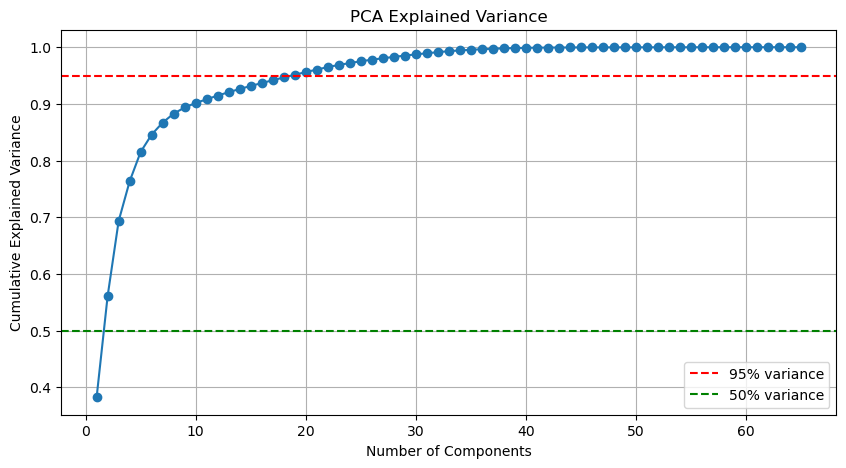

In [63]:

# Plot explained variance to choose number of components
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.50, color='g', linestyle='--', label='50% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


In [64]:


n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
# n components to explain 80% of the varence 
n_components = n_components_80 

print(f'Components needed for 80% variance: {n_components_80}')
print(f'Using n_components = {n_components} ')
print(f'Variance explained: {cumulative_variance[n_components-1]:.2%}')


pca = PCA(n_components=n_components)
X_pca_80_percent = pca.fit_transform(X_PCA)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"confirm varience explained when fit_transform with only {n_components}")
print(f'Variance explained: {cumulative_variance[-1]:.2%}')


Components needed for 80% variance: 5
Using n_components = 5 
Variance explained: 81.53%
confirm varience explained when fit_transform with only 5
Variance explained: 81.53%


## Cluster on PCA


### Find the optimal cluster size using silhouette_score

In [65]:
sample_size = 50000 #save some time with random subsampleing
sample_idx = np.random.choice(len(X_pca_80_percent), sample_size, replace=False)
X_pca_sample = X_pca_80_percent[sample_idx]

k_range = range(2,11)
silhouette_scores = []

for k in k_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(X_pca_sample)
    s = silhouette_score(X_pca_sample, labels=labels_tmp)
    silhouette_scores.append(s)
    print(f"k={k}:   Silhouette_score: {s}")

best_k = k_range[np.argmax(silhouette_scores)]


k=2:   Silhouette_score: 0.2954590682225723
k=3:   Silhouette_score: 0.23628949198122645
k=4:   Silhouette_score: 0.22432203308407453
k=5:   Silhouette_score: 0.2152583897234678
k=6:   Silhouette_score: 0.21235385150932415
k=7:   Silhouette_score: 0.20109278958541266
k=8:   Silhouette_score: 0.19553895824361417
k=9:   Silhouette_score: 0.1963063200160082
k=10:   Silhouette_score: 0.19354024015898616


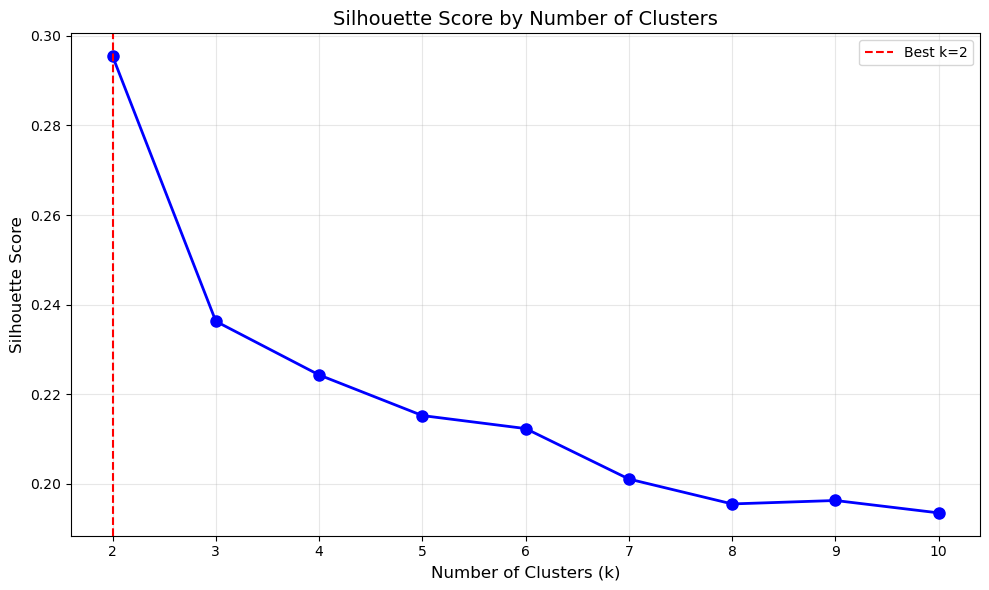

In [66]:
# Visually show the silhouet scores 
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score by Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Fit KMeans with the k=2
No longer use the subsample.
The best k is 2.

In [93]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_80_percent)



## Display Results

In [94]:
df_left['cluster'] = clusters

print(f"\nCluster sizes:")
print(df_left['cluster'].value_counts().sort_index())


Cluster sizes:
cluster
0    143484
1     99042
Name: count, dtype: int64


In [95]:
#print out cluster results

for cluster_id in range(2):
    cluster_data = df_left[df_left['cluster'] == cluster_id]
    print(f"Cluster id = {cluster_id} \n")

    print('Turnover Reason Distribution:')
    print(" Reason,                  Count,    Percentage")
    reason_dist = cluster_data['turnover_reason'].value_counts()
    for reason, count in reason_dist.items():
        p = count / len(cluster_data)
        print(f" {reason},  {count},  ({p*100}%)")

    print('')
    print('')


Cluster id = 0 

Turnover Reason Distribution:
 Reason,                  Count,    Percentage
 Burnout / Work-Life Balance,  82470,  (57.47679183741741%)
 Compensation / Role Dissatisfaction,  29638,  (20.655961640322264%)
 Personal / Relocation,  24981,  (17.410303587856486%)
 Involuntary (Performance),  3695,  (2.5752000223021385%)
 Career Opportunity,  2604,  (1.8148364974491928%)
 Personal Reasons (Anomaly),  96,  (0.06690641465250481%)


Cluster id = 1 

Turnover Reason Distribution:
 Reason,                  Count,    Percentage
 Personal / Relocation,  49197,  (49.672866056824375%)
 Burnout / Work-Life Balance,  25269,  (25.513418549706184%)
 Personal Reasons (Anomaly),  9427,  (9.518184204680843%)
 Involuntary (Performance),  5201,  (5.251307526100038%)
 Compensation / Role Dissatisfaction,  5026,  (5.0746148098786374%)
 Career Opportunity,  4922,  (4.969608852809919%)




The first cluster mainly consists of employees who left for "Burnout / Work-Life Balance" reasons or "Compensation / Role Dissatisfaction" reasons. these two reasons took make up 78% for the points in the cluster. The second cluster consists of ~50% employees who relocated for personal reasons "Personal / Relocation". These are two very different reasons for leaving a company. With this new information we will train two models based on this segmented data. For the first model left_company column will only contain employees who left for Burnout / Work-Life Balance or Compensation / Role Dissatisfaction. The second model the left_company column will contain the other reasons "Personal / Relocation", "Personal Reasons (Anomaly)", "Involuntary (Performance)", "Career Opportunity"

## Encode Cluster results

In [31]:
train_clusters_encoded = pd.get_dummies(train_clusters, prefix='cluster', drop_first=True)
test_clusters_encoded = pd.get_dummies(test_clusters, prefix='cluster', drop_first=True)
test_clusters_encoded = test_clusters_encoded.reindex(columns=train_clusters_encoded.columns, fill_value=0)

#merge with columns not used in PCA
X_train_final = pd.concat([other_features.reset_index(drop=True), train_clusters_encoded.reset_index(drop=True)], axis=1)
print(f'Shape of final X training set: {X_train_final.shape}')
X_test_final = pd.concat([other_features_test.reset_index(drop=True), test_clusters_encoded.reset_index(drop=True)], axis=1)
print(f'Shape of final X test set: {X_test_final.shape}')

Shape of final X training set: (679999, 14)
Shape of final X test set: (170000, 14)


# Train the random forest again!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

In [98]:
# Model evaluation
def evaluate_model(y_true, y_pred, dataset):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_pred)
  print(dataset)
  print('Accuracy:', acc)
  print('Precision:', prec)
  print('Recall:', rec)
  print('F1-Score:', f1)
  print('ROC-AUC:', roc)

In [ ]:
c1_reason_subset_df = df[(df['turnover_reason'] == 'Burnout / Work-Life Balance') | 
                         (df['turnover_reason'] == 'Compensation / Role Dissatisfaction') |
                         (df['turnover_reason'] == 'Not Applicable')].copy() #NA for left_company = False

c2_reason_subset_df = df[(df['turnover_reason'] != 'Burnout / Work-Life Balance') & 
                         (df['turnover_reason'] != 'Compensation / Role Dissatisfaction')].copy()

In [103]:
categorical_vars = [ 'job_level', 'department', 'persona_name']


feature_cols = ['email_sentiment',
                'satisfaction_score',
                'burnout_risk', 
                'stress_level', 
                'collaboration_score', 
                'meeting_participation', 
                'slack_activity',
                'project_completion_rate', 
                'feedback_sentiment_score',
                'workload_score',
                'goal_achievement_rate',
                'performance_score',
                'overtime_hours']

In [104]:
c1_reason_subset_df = c1_reason_subset_df[feature_cols+categorical_vars+['left_company']].copy()



In [105]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X = c1_reason_subset_df[feature_cols+categorical_vars]
y = c1_reason_subset_df['left_company']

X_train_c1, X_test_c1, y_train_c1, y_test_c1 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify if classification
)

#consice but it needs to be converted back to pd df
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
    ])

X_train_c1_transformed = preprocessor.fit_transform(X_train_c1)
X_test_c1_transformed = preprocessor.transform(X_test_c1)

num_features = feature_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)
all_features = list(num_features) + list(cat_features)

X_train_c1_t = pd.DataFrame(X_train_c1_transformed, columns=all_features, index=X_train_c1.index)
X_test_c1_t = pd.DataFrame(X_test_c1_transformed, columns=all_features, index=X_test_c1.index)


Using 'Burnout / Work-Life Balance' and 'Compensation / Role Dissatisfaction' 
Train Set
Accuracy: 0.6938255999719106
Precision: 0.6325660699062233
Recall: 0.9248784255894383
F1-Score: 0.7512906077978381
ROC-AUC: 0.6938255999719106


Test Set
Accuracy: 0.5476327596598138
Precision: 0.2867093928442751
Recall: 0.922018187563639
F1-Score: 0.4374042241321874
ROC-AUC: 0.6907089671775446


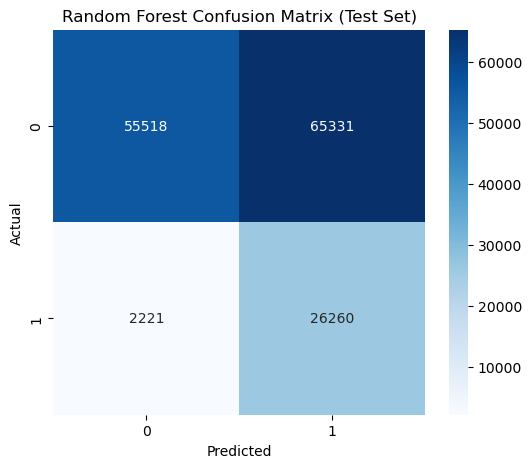

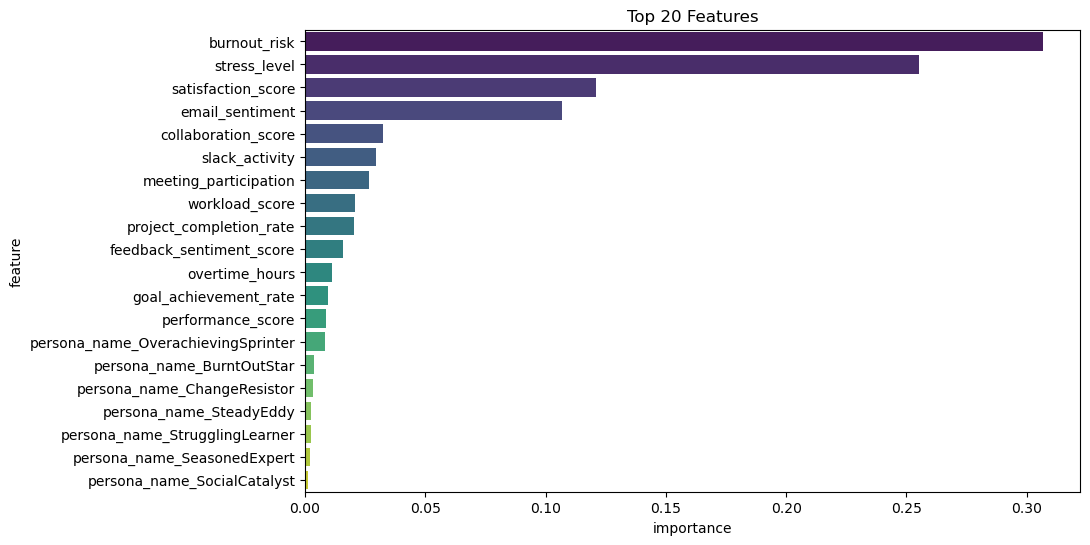

In [113]:
print("Using 'Burnout / Work-Life Balance' and 'Compensation / Role Dissatisfaction' " )

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_c1_t, y_train_c1)

# Initialize model
rf_model_1 = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    random_state=42,
    bootstrap=True,
    class_weight='balanced_subsample',
    n_jobs=-1
)

# Fit model
rf_model_1.fit(X_train_res, y_train_res)

y_train_pred = rf_model_1.predict(X_train_res)
y_test_pred = rf_model_1.predict(X_test_c1_t)

# Evaluate
evaluate_model(y_train_res, y_train_pred, 'Train Set')
print('\n')
evaluate_model(y_test_c1, y_test_pred, 'Test Set')

# Confusion matrix
cm = confusion_matrix(y_test_c1, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importances
importances = rf_model_1.feature_importances_
features = X_train_res.columns
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')
plt.title('Top 20 Features')
plt.show()



In [115]:
X = c2_reason_subset_df[feature_cols+categorical_vars]
y = c2_reason_subset_df['left_company']

X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify if classification
)

#consice but it needs to be converted back to pd df
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_vars)
    ])

X_train_c2_transformed = preprocessor.fit_transform(X_train_c2)
X_test_c2_transformed = preprocessor.transform(X_test_c2)

num_features = feature_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)
all_features = list(num_features) + list(cat_features)

X_train_c2_t = pd.DataFrame(X_train_c2_transformed, columns=all_features, index=X_train_c2.index)
X_test_c2_t = pd.DataFrame(X_test_c2_transformed, columns=all_features, index=X_test_c2.index)


NOT using 'Burnout / Work-Life Balance' and 'Compensation / Role Dissatisfaction' 
Train Set
Accuracy: 0.6382056980199255
Precision: 0.6146532438478747
Recall: 0.7409173762141377
F1-Score: 0.6719048966883668
ROC-AUC: 0.6382056980199255


Test Set
Accuracy: 0.5613835500282646
Precision: 0.2062045835662381
Recall: 0.7368789013732834
F1-Score: 0.3222361740459682
ROC-AUC: 0.6346685136110419


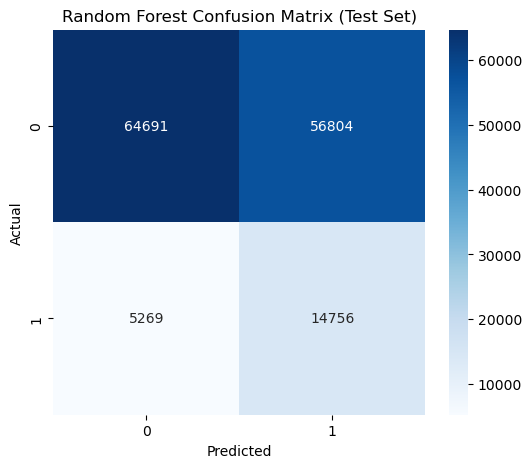

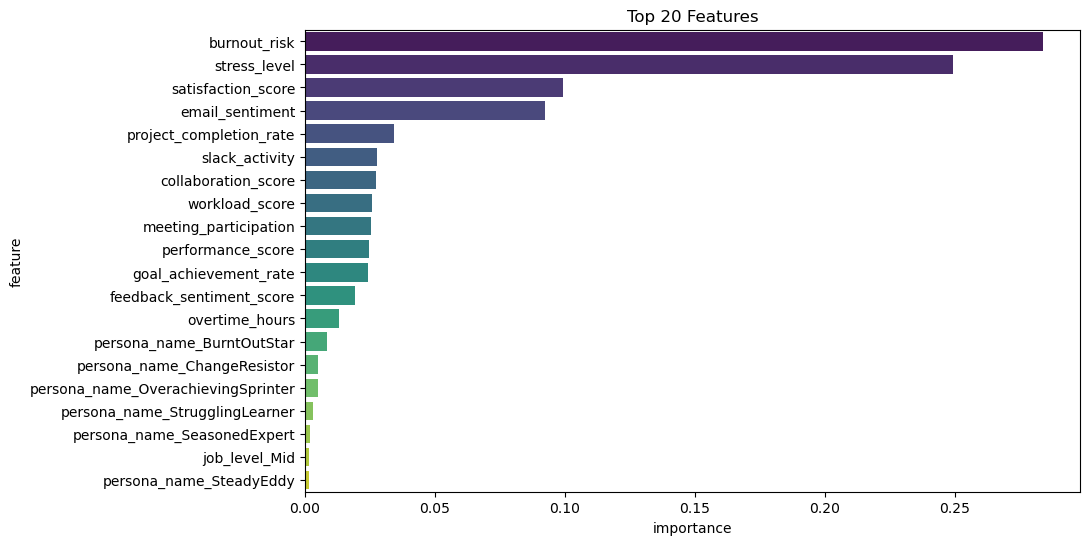

In [117]:
print("NOT using 'Burnout / Work-Life Balance' and 'Compensation / Role Dissatisfaction' " )

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_c2_t, y_train_c2)

# Initialize model
rf_model_1 = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    random_state=42,
    bootstrap=True,
    class_weight='balanced_subsample',
    n_jobs=-1
)

# Fit model
rf_model_1.fit(X_train_res, y_train_res)

y_train_pred = rf_model_1.predict(X_train_res)
y_test_pred = rf_model_1.predict(X_test_c2_t)

# Evaluate
evaluate_model(y_train_res, y_train_pred, 'Train Set')
print('\n')
evaluate_model(y_test_c2, y_test_pred, 'Test Set')

# Confusion matrix
cm = confusion_matrix(y_test_c2, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importances
importances = rf_model_1.feature_importances_
features = X_train_res.columns
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')
plt.title('Top 20 Features')
plt.show()

